In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Stimulus_Description.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/ReadME.txt
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Single Modal_Use.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/ECGdata_s3p12v3.dat
/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Single Modal/ECG/ECGd

# Make prediction on arousal (stress level) using arousal level from GSR labelled data

In [2]:
import pandas as pd
import re
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , roc_auc_score ,roc_curve , ConfusionMatrixDisplay , RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import scipy.stats as stat

# Prepare necessary files

1. stimulus : description of videos used to stimulate the subject's emotion
2. gsr_data : raw data obtained from experiment
3. gsr_summary : processed dataframe by using statistical summary of each record
4. gsr_proc : processed dataframe by using time-series data of each record



# Stimulus Information

Contains info on videos used in experiment

In [3]:
stimulus = pd.read_excel("/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Stimulus_Description.xlsx")
stimulus["Target Emotion"] = stimulus["Target Emotion"].str.title()
stimulus.info()
stimulus.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Session ID            21 non-null     int64 
 1   Video ID              21 non-null     int64 
 2   Target Emotion        21 non-null     object
 3   Title of Video Clip   21 non-null     object
 4   Time Duration (secs)  21 non-null     int64 
 5   Active Link of Video  21 non-null     object
dtypes: int64(3), object(3)
memory usage: 1.1+ KB


,Session ID,Video ID,Target Emotion,Title of Video Clip,Time Duration (secs),Active Link of Video
0,1,1,Happy,Best Babies Laughing Video Compilation,39,https://drive.google.com/file/d/1ZWD1zyWkHcBI0...
1,1,2,Sad,Barely There,39,https://drive.google.com/file/d/13ysQgSsBwy3d8...
2,1,3,Neutral,Denali National Park Alaska,39,https://drive.google.com/file/d/1En_ARj18JlBLP...
3,1,4,Surprise,World's Highest Commercially Rafted Waterfall,39,https://drive.google.com/file/d/1kCIHXEklgpWds...
4,1,5,Disgust,Disgusting video compilation,39,https://drive.google.com/file/d/1mclmT0EAA-oZ6...


# GSR Data

Raw GSR data will be joined to the experiment's result

In [4]:
# For first run only
gsr_data=pd.read_excel("/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Self-Annotation Labels/Self-annotation Multimodal_Use.xlsx")
gsr_data["filename"]="GSRdata_s"+gsr_data["Session ID"].astype(str)+"p"+gsr_data["Participant Id"].astype(str)+"v"+gsr_data["Video ID"].astype(str)+".dat"
PATH_2="/kaggle/input/young-adults-affective-data-ecg-and-gsr-signals/ECG_GSR_Emotions/Raw Data/Multimodal/GSR/"
gsr_data["filename"]=gsr_data["filename"].str.replace('GSRdata_s2p9v3.dat','GSRdata_S2p9v3.dat',regex=False)
gsr_data["GSR_list"]=gsr_data["filename"].apply(lambda x: list(pd.read_table(PATH_2+x).iloc[:,0]))
gsr_data=gsr_data.merge(stimulus.iloc[:,0:3],on=["Session ID","Video ID"])
gsr_data.to_csv("gsr_data.csv",index=False)

In [5]:
gsr_data = pd.read_csv("/kaggle/working/gsr_data.csv")
gsr_data.info()
gsr_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Participant Id     252 non-null    int64 
 1   Session ID         252 non-null    int64 
 2   Video ID           252 non-null    int64 
 3   Name               252 non-null    object
 4   Age                252 non-null    int64 
 5   Gender             252 non-null    object
 6   Valence level      252 non-null    int64 
 7   Arousal level      252 non-null    int64 
 8   Dominance level    252 non-null    int64 
 9   Happy              252 non-null    object
 10  Sad                252 non-null    object
 11  Fear               252 non-null    object
 12  Anger              252 non-null    object
 13  Neutral            252 non-null    object
 14  Disgust            252 non-null    object
 15  Surprised          252 non-null    object
 16  Familiarity Score  113 non-null    object
 1

,Participant Id,Session ID,Video ID,Name,Age,Gender,Valence level,Arousal level,Dominance level,Happy,...,Disgust,Surprised,Familiarity Score,Emotion,V_Label,A_Label,Four_Labels,filename,GSR_list,Target Emotion
0,1,1,1,M_M,13,Female,8,0,0,High,...,VeryLow,VeryLow,Never watched,Happy,HV,LA,HVLA,GSRdata_s1p1v1.dat,"[246.41, 246.59, 246.52, 246.58, 246.87, 247.0...",Happy
1,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,VeryLow,NaN,Sad,LV,LA,LVLA,GSRdata_s1p1v2.dat,"[254.91, 255.06, 255.02, 255.05, 255.12, 255.0...",Sad
2,1,1,2,M_M,13,Female,4,0,0,VeryLow,...,VeryLow,Low,NaN,Surprise,LV,LA,LVLA,GSRdata_s1p1v2.dat,"[254.91, 255.06, 255.02, 255.05, 255.12, 255.0...",Sad
3,1,1,4,M_M,13,Female,9,0,0,VeryHigh,...,VeryLow,VeryLow,NaN,Happy,HV,LA,HVLA,GSRdata_s1p1v4.dat,"[437.83, 438.21, 438.14, 438.2, 438.15, 438.19...",Surprise
4,1,1,5,M_M,13,Female,0,9,0,VeryLow,...,VeryHigh,VeryLow,NaN,Disgust,LV,HA,LVHA,GSRdata_s1p1v5.dat,"[451.61, 451.45, 451.6, 451.18, 451.54, 451.51...",Disgust


# Feature Extraction from GSR Data 

2 different feature extraction methods:

1. statistical summary
* min
* max
* mean
* variance
* skewness
* kurtosis

for each GSR record

2. Take lists containing the GSR record for each row and break list into individual columns. Each of the individual column represents a time-series record index


**Feature Extraction with Statistical Summary**

In [6]:
# import ast
# print(gsr_summary['GSR_list'].head())

# gsr_summary.shape

# def safe_literal_eval(val):
#     try:
#         return ast.literal_eval(val)
#     except (ValueError, SyntaxError):
#         return None  # or handle invalid entries as needed

# gsr_summary["GSR_list"] = gsr_summary["GSR_list"].apply(safe_literal_eval)

# gsr_summary = gsr_summary.dropna(subset=["GSR_list"])
# gsr_summary.shape

# CODE BELOW USES EMOTION 
# # For first run only
gsr_summary=gsr_data[["Emotion","GSR_list"]].copy()
gsr_summary["GSR_list"]=gsr_summary["GSR_list"].apply(lambda x: ast.literal_eval(x))
gsr_summary["min"]=gsr_summary["GSR_list"].apply(lambda x: np.min(x))
gsr_summary["max"]=gsr_summary["GSR_list"].apply(lambda x: np.max(x))
gsr_summary["mean"]=gsr_summary["GSR_list"].apply(lambda x: np.mean(x))
gsr_summary["variance"]=gsr_summary["GSR_list"].apply(lambda x: np.var(x))
gsr_summary["kurtosis"]=gsr_summary["GSR_list"].apply(lambda x: stat.kurtosis(x))
gsr_summary["skewness"]=gsr_summary["GSR_list"].apply(lambda x: stat.skew(x))
gsr_summary=gsr_summary.drop(columns=["GSR_list"])

gsr_summary.to_csv("gsr_summary.csv",index=False)



# NEW VERSION TO USE AROUSAL INSTEAD OF EMOTION

# Define a function to compute all summary statistics at once
def compute_gsr_stats(x):
    gsr_list = ast.literal_eval(x)
    return pd.Series({
        "min": np.min(gsr_list),
        "max": np.max(gsr_list),
        "mean": np.mean(gsr_list),
        "variance": np.var(gsr_list),
        "kurtosis": stat.kurtosis(gsr_list),
        "skewness": stat.skew(gsr_list)
    })

# Apply the function and drop "GSR_list" column
gsr_summary_arousal = gsr_data[['Arousal level','GSR_list']].copy()
gsr_summary_arousal = gsr_summary_arousal.join(gsr_summary_arousal["GSR_list"].apply(compute_gsr_stats))
gsr_summary_arousal = gsr_summary_arousal.drop(columns=["GSR_list"])
# Save the summary to CSV
gsr_summary_arousal.to_csv("gsr_summary_arousal.csv", index=False)

In [7]:
print(gsr_summary)

      Emotion      min     max        mean     variance  kurtosis  skewness
0       Happy  230.720  270.98  255.140222    95.695503 -1.154363  0.013905
1         Sad  251.020  301.51  279.765019   364.673363 -1.539416 -0.385271
2    Surprise  251.020  301.51  279.765019   364.673363 -1.539416 -0.385271
3       Happy  318.150  441.93  388.395303  1129.494325 -0.895524 -0.396455
4     Disgust  438.780  540.52  506.871458   525.575774  0.753612 -1.134248
..        ...      ...     ...         ...          ...       ...       ...
247     Mixed  259.450  385.76  355.894745   611.723574  3.488410 -1.761400
248     Happy   93.007  153.69  123.619144   239.574008 -0.971576 -0.023120
249     Mixed  298.530  399.61  368.869246  1255.327299 -1.093433 -0.828050
250     Anger  420.700  547.10  494.407774  1106.346023 -1.102623 -0.045683
251      Fear  360.020  417.65  385.588598   134.792341 -0.357893 -0.270342

[252 rows x 7 columns]


In [8]:
print(gsr_summary_arousal)

# TODO DECIDE LEVEL OF AROUSAL THAT NEEDS TO BE FLAGGED
# EG. ABOVE 4 -> STRESSED

     Arousal level      min     max        mean     variance  kurtosis  \
0                0  230.720  270.98  255.140222    95.695503 -1.154363   
1                0  251.020  301.51  279.765019   364.673363 -1.539416   
2                0  251.020  301.51  279.765019   364.673363 -1.539416   
3                0  318.150  441.93  388.395303  1129.494325 -0.895524   
4                9  438.780  540.52  506.871458   525.575774  0.753612   
..             ...      ...     ...         ...          ...       ...   
247              9  259.450  385.76  355.894745   611.723574  3.488410   
248              0   93.007  153.69  123.619144   239.574008 -0.971576   
249              0  298.530  399.61  368.869246  1255.327299 -1.093433   
250              7  420.700  547.10  494.407774  1106.346023 -1.102623   
251              3  360.020  417.65  385.588598   134.792341 -0.357893   

     skewness  
0    0.013905  
1   -0.385271  
2   -0.385271  
3   -0.396455  
4   -1.134248  
..        ...  

In [9]:
gsr_summary=pd.read_csv("/kaggle/working/gsr_summary.csv")
gsr_summary.info()
gsr_summary.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   252 non-null    object 
 1   min       252 non-null    float64
 2   max       252 non-null    float64
 3   mean      252 non-null    float64
 4   variance  252 non-null    float64
 5   kurtosis  252 non-null    float64
 6   skewness  252 non-null    float64
dtypes: float64(6), object(1)
memory usage: 13.9+ KB


,Emotion,min,max,mean,variance,kurtosis,skewness
0,Happy,230.72,270.98,255.140222,95.695503,-1.154363,0.013905
1,Sad,251.02,301.51,279.765019,364.673363,-1.539416,-0.385271
2,Surprise,251.02,301.51,279.765019,364.673363,-1.539416,-0.385271
3,Happy,318.15,441.93,388.395303,1129.494325,-0.895524,-0.396455
4,Disgust,438.78,540.52,506.871458,525.575774,0.753612,-1.134248


# Feature Extraction with time-series

In [10]:
# for first run only

# CODE BELOW IS FOR EMOTION
# gsr_proc = gsr_data[['Emotion','GSR_list']].copy()
# gsr_proc['GSR_list'] = gsr_proc['GSR_list'].apply(lambda x: ast.literal_eval(x))
# gsr_proc = pd.concat([gsr_proc,pd.DataFrame(gsr_proc['GSR_list'].tolist())],axis=1).drop(columns=['GSR_list'])
# for i in range(gsr_proc.shape[1]-1):
#     gsr_proc[i]=pd.to_numeric(gsr_proc[i])
# gsr_proc.to_csv('gsr_proc.csv' , index=False)    


# CODE BELOW IS FOR AROUSAL
gsr_proc=gsr_data[['Arousal level','GSR_list']].copy()
gsr_proc['GSR_list']=gsr_proc['GSR_list'].apply(lambda x: ast.literal_eval(x))
gsr_proc=pd.concat([gsr_proc,pd.DataFrame(gsr_proc['GSR_list'].tolist())],axis=1).drop(columns=['GSR_list'])
for i in range(gsr_proc.shape[1]-1):
    gsr_proc[i]=pd.to_numeric(gsr_proc[i])
gsr_proc.to_csv('gsr_proc.csv', index=False)

In [11]:
gsr_proc=pd.read_csv('/kaggle/working/gsr_proc.csv')
gsr_proc.info()
gsr_proc.head()

# print(gsr_proc['Arousal level'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Columns: 5000 entries, Arousal level to 4998
dtypes: float64(4999), int64(1)
memory usage: 9.6 MB


,Arousal level,0,1,2,3,4,5,6,7,8,...,4989,4990,4991,4992,4993,4994,4995,4996,4997,4998
0,0,246.41,246.59,246.52,246.58,246.87,247.04,247.06,247.13,247.33,...,265.76,265.67,265.65,265.77,265.76,265.67,265.65,265.67,265.65,265.67
1,0,254.91,255.06,255.02,255.05,255.12,255.06,255.20,255.17,255.20,...,299.89,299.90,299.78,299.62,299.89,299.91,299.77,299.76,299.90,299.90
2,0,254.91,255.06,255.02,255.05,255.12,255.06,255.20,255.17,255.20,...,299.89,299.90,299.78,299.62,299.89,299.91,299.77,299.76,299.90,299.90
3,0,437.83,438.21,438.14,438.20,438.15,438.19,438.43,438.23,438.13,...,413.23,413.15,413.47,413.18,413.20,413.18,413.44,413.45,413.45,413.20
4,9,451.61,451.45,451.60,451.18,451.54,451.51,451.54,451.52,451.53,...,509.74,510.03,509.04,509.90,509.89,509.53,509.84,509.57,509.80,509.61


In [12]:
print(gsr_proc['Arousal level'].max())

# TODO ADD ANOTHER COLUMN TO INCLUDE STRESS LEVEL
# ALL ROWS WITH AROUSAL LEVEL OF 5 & ABOVE SHOULD HAVE 'STRESSED'
# OTHERS SHOULD BE NOT STRESSED

# Add 'Stress level' column based on 'Arousal level' - STRESSED IF AROUSAL >=5
gsr_proc['Stress Level']=np.where(gsr_proc['Arousal level']>=5, 'STRESSED','NOT STRESSED')

print(gsr_proc)

9
     Arousal level        0        1       2        3        4       5  \
0                0  246.410  246.590  246.52  246.580  246.870  247.04   
1                0  254.910  255.060  255.02  255.050  255.120  255.06   
2                0  254.910  255.060  255.02  255.050  255.120  255.06   
3                0  437.830  438.210  438.14  438.200  438.150  438.19   
4                9  451.610  451.450  451.60  451.180  451.540  451.51   
..             ...      ...      ...     ...      ...      ...     ...   
247              9  357.430  357.320  357.24  356.950  357.030  356.78   
248              0   93.036   93.054   93.04   93.007   93.036   93.01   
249              0  388.820  388.660  388.80  388.900  389.010  388.92   
250              7  420.800  420.700  421.04  420.990  421.290  421.53   
251              3  417.640  417.550  417.38  417.520  417.650  417.54   

           6        7        8  ...    4990    4991    4992    4993    4994  \
0    247.060  247.130  247.330

In [13]:
# Count the number of 'STRESSED' and 'NOT STRESSED' rows
stress_counts = gsr_proc['Stress Level'].value_counts()

print(stress_counts)

Stress Level
NOT STRESSED    163
STRESSED         89
Name: count, dtype: int64


# Check if current decision to assign those with arousal level of 5 and above to be stressed is fine

**Currently, there are more records of 'NOT STRESSED' based on arousal level 5 & above**

168 records with arousal level less than 5

89 records with arousal level 5 & above

To deal with data imbalance- Methods:

1. Resampling : SMOTE,Random Oversampling,Undersampling majority class

2. Class Weighting
* ML algorithms allow to set class weights 
* class_weight='balanced'

# Exploratory Data Analysis

 Experiment Result
 
 There were confusion matrix done to see relationship with target emotion of video shown & actual emotion invoked
 
 IGNORE FOR NOW

# Plotting GSR for stress level

<Figure size 640x480 with 0 Axes>

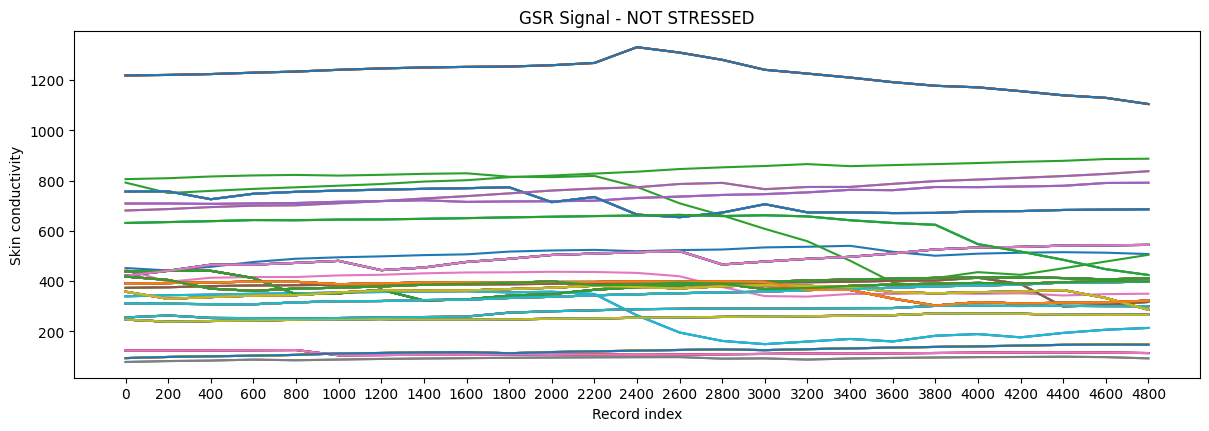

<Figure size 640x480 with 0 Axes>

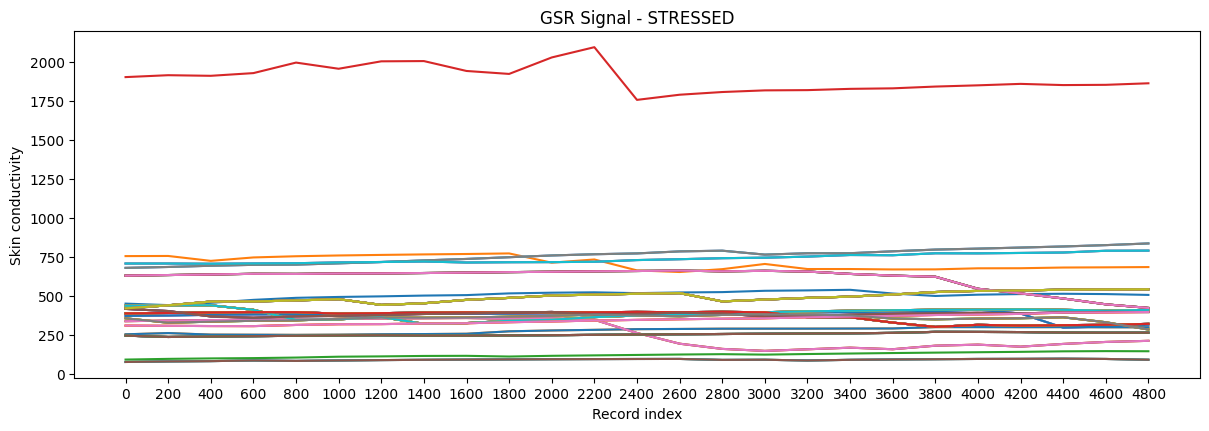

In [14]:
stress_level=['NOT STRESSED', 'STRESSED']

def plot_signals(data_arr , title=''):
    plt.clf()
    plt.figure(figsize=(12,4))
    
    for index,row in data_arr.iterrows():
        y=row
        plt.plot(y)
        
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('Skin conductivity')
    plt.xlabel('Record index')
    plt.show()

for i in stress_level:
    plot_signals(gsr_proc[gsr_proc['Stress Level']==i].iloc[:,1:4998:200], "GSR Signal - "+i)

# Can look for changes in skin conductivity over time instead